# Sequences and Recurrent Neural Networks

The examples of sequential data:

* Time-series
* Audio
* Signals

The train/test split is the out-of-time to prevent "look-ahead" bias.

<img src="./img/diagram-lstm.png" alt="time-series" style="width: 600px;"/>

In [ ]:
import torch
from torch import nn

In [2]:
import pandas as pd

# Dataset

In [3]:
df = pd.read_csv('./data/electricityloaddiagrams20112014/LD2011_2014.txt', delimiter=';',low_memory=False)

In [4]:
df.shape

(140256, 371)

We need to set the sequence length -> number of datapoints in one training example. 

The time frequency of the dataset is every 15 minutes. 

If we want to predict consumption based on the last 24 hours, we need to build a sequence of 24*4 observations.

In [5]:
df.rename(columns={'Unnamed: 0': 'tm'}, inplace=True)

In [6]:
import numpy as np

In [7]:
# selecting x-customer MT_124
consumption = df.loc[:, 'MT_124'].str.replace(',', '.')

In [8]:
consumption = pd.to_numeric(consumption)

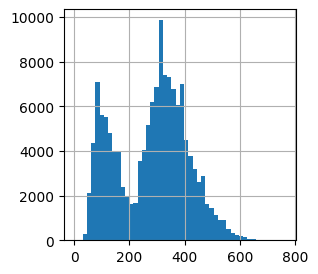

In [9]:
_ = consumption.hist(bins=50, figsize=(3,3))

In [10]:
# z-score normalization
mu = consumption.mean()
std = consumption.std()
consumption = (consumption - mu) /std

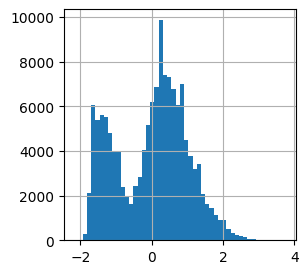

In [11]:
_ = consumption.hist(bins=50, figsize=(3,3))

The shape of the data remains the same but the values are now spread around 0.

In [12]:
consumption.shape[0]

140256

In [13]:
def sequence(df, seq_length):
    xs, ys = [], []
    for i in range(len(df)-seq_length):
        x = df[i:(i+seq_length)]
        y = df[i+seq_length]
        xs.append(x), ys.append(y)
    return np.array(xs), np.array(ys)

In [14]:
train_feat, train_label = sequence(consumption[:112204].to_numpy(), 24*4)

In [15]:
train_feat.shape, train_label.shape

((112108, 96), (112108,))

In [16]:
test_feat, test_label = sequence(consumption[112204:].to_numpy(), 24*4)

In [17]:
test_feat.shape, test_label.shape

((27956, 96), (27956,))

### Torch Dataset

In [38]:
BATCH_SIZE = 32

In [32]:
from torch.utils.data import TensorDataset, DataLoader

In [21]:
dataset_train = TensorDataset(
    torch.from_numpy(train_feat).float(),
    torch.from_numpy(train_label).float(),
)

In [22]:
dataset_test = TensorDataset(
    torch.from_numpy(test_feat).float(),
    torch.from_numpy(test_label).float(),
)

In [39]:
train_loader = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [40]:
test_loader = DataLoader(
    dataset_test,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# RNN

<img src="./img/rnn.png" alt="rnn" style="width: 400px;"/>

RNN mantains memory cell via hidden state.

In [92]:
# sequence to vector
class RNNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.rnn(x,h0)
        out = self.fc(out[:, -1: :])
        return out

# LSTM

Long Short Term Memory

<img src="./img/lstm_cell.png" alt="lstm" style="width: 400px;"/>

LSTM cell has tho hidden layers:

* h - short-term memory
* c - long-term memory

It has three "gates":

* input - saves data to long-term memory
* forget - removes data from long-term memory
* output - returns data to current time step

In [111]:
class LSTMNet(nn.Module):
    def __init__(self, input_size=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=32,
            num_layers=2,
            batch_first=True
        )
        self.fc = nn.Linear(32,1)

    def forward(self,x):
        h0 = torch.zeros(2, x.size(0), 32)
        c0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1: 1])
        return out

# GRU
Gated Recurrent Unit is simplified version of LSTM.

It merges long and short term memory cells into one hidden state and doesn't have "output" gate.

<img src="./img/gru_cell.png" alt="gru" style="width: 400px;"/>

In [110]:
class GRUNet(nn.Module):
    def __init__(self, input_size=1):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=32,
            num_layers=2,
            batch_first=True
        )
        self.fc = nn.Linear(32,1)

    def forward(self,x):
        print(x.shape)
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1: 1])
        return out

# Training and Evaluation

Recurrent layer expects input shape (batch_size, seg_length, num_features).

### Expanding tensor to add features

The data loader is in the shape of (batch_size, seq_length), so we need to add dimention for features.

In [107]:
# load first batch
sequences, labels = next(iter(train_loader))

In [108]:
# batch_size, seq_length
sequences.size()

torch.Size([32, 96])

Add dimention for features

In [106]:
sequences = sequences.view(32,96,1)
sequences.size()

torch.Size([32, 96, 1])

### Squeezing tensor to get predictions

Labels are in shape (batch_size) but model outputs are in shape (batch_size, 1).

The shape of model outputs and labels must match for loss function, so we need to drop last dimension from model outputs.

In [48]:
labels.shape

torch.Size([32])

In [ ]:
out = net(sequences).squeeze()

### Training loop

In [79]:
import torch.optim as optim

In [112]:
net = GRUNet()

In [114]:
loss_function = nn.MSELoss() # mean squared error

In [115]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    for seqs, labels in train_loader:
        seqs = seqs.view(BATCH_SIZE, 96, 1)
        outputs = net(seqs)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### Evaluation loop

In [118]:
from torchmetrics.regression import MeanSquaredError

In [119]:
eval_function = MeanSquaredError() 

In [ ]:
net.eval()
# iterate without gradients
with torch.no_grad():
    for seqs, labels in test_loader:
        seqs = seqs.view(BATCH_SIZE, 96, 1)
        print(seqs.size())
        outputs = net(seqs).squeeze()
        eval_function(outputs, labels)

eval_function.compute()

In [135]:
seqs.size()

torch.Size([32, 96, 1])

In [ ]:
output [batch_size, nb_classes, *additional_dims] 
label  [batch_size, *additional_dims] 